In [1]:
from models.gan_model import *
from models.networks import *
import torch
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch.utils.data import TensorDataset, DataLoader
import networkx as nx

In [2]:
root = './enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset = TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

ENZYMES(600)


In [3]:
def fix_size_adj(graph):
    input_tensor = to_dense_adj(graph.edge_index)
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(1, input_tensor.shape[1], 42 - input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros], dim=2)

        zeros = torch.zeros(1, 42 - input_tensor.shape[1], 42)
        tensor = torch.cat([tensor, zeros], dim=1)
        return tensor
    else:
        return input_tensor
    
    
def fix_size_feat(graph):
    input_tensor = graph.x
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(42 - input_tensor.shape[0], input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros])
        return tensor
    else:
        return input_tensor

In [4]:
graphs_relevance = [g for g in pyg_dataset if g.num_nodes in [38, 40, 42]]
graphs = torch.zeros(71, 1, 42, 42)
features = torch.zeros(71, 1, 42, 3)
for i in range(len(graphs_relevance)):
    graphs[i] = fix_size_adj(graphs_relevance[i])
    features[i] = fix_size_feat(graphs_relevance[i])

In [5]:
batch_size = 16
z_size = 100
graphs_dataset = TensorDataset(graphs)
graphs_dataloader = DataLoader(graphs_dataset, batch_size)

features_dataset = TensorDataset(features)
features_dataloader = DataLoader(features_dataset, batch_size)

In [6]:
graph_gan = GraphGAN(num_vertex=42)
feature_gan = GraphGAN(num_vertex=42, generator=FeatureGenerator(z_size, 42, 3), discriminator=FeatureDiscriminator(42, 3))

In [7]:
def train(model, dataloader, num_epochs=10, print_every=1):
    for epoch in range(num_epochs):
        g_l = 0
        d_l = 0
        for batch in dataloader:
            data = batch[0]
            image_size = data.size(0)

            gl, dl = model.forward(data, image_size)
            g_l += gl
            d_l += dl
        if epoch % print_every == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(num_epochs)
                  + "\td_loss:" + str(round(d_l / len(dataloader), 4))
                  + "\tg_loss:" + str(round(g_l / len(dataloader), 4))
                  )

In [8]:
train(graph_gan, graphs_dataloader, num_epochs=30, print_every=10)

Epoch: 1/30	d_loss:0.9168	g_loss:3.4797
Epoch: 11/30	d_loss:0.0937	g_loss:5.2725
Epoch: 21/30	d_loss:0.0137	g_loss:16.7022


In [9]:
train(feature_gan, features_dataloader, num_epochs=30, print_every=10)

Epoch: 1/30	d_loss:1.1708	g_loss:0.9204
Epoch: 11/30	d_loss:0.534	g_loss:1.5526
Epoch: 21/30	d_loss:0.4615	g_loss:3.5177


In [10]:
graph_output = graph_gan.generate_adj(return_symmetric=True).squeeze().detach().numpy()

In [11]:
G = nx.from_numpy_array(graph_output, create_using=nx.Graph())

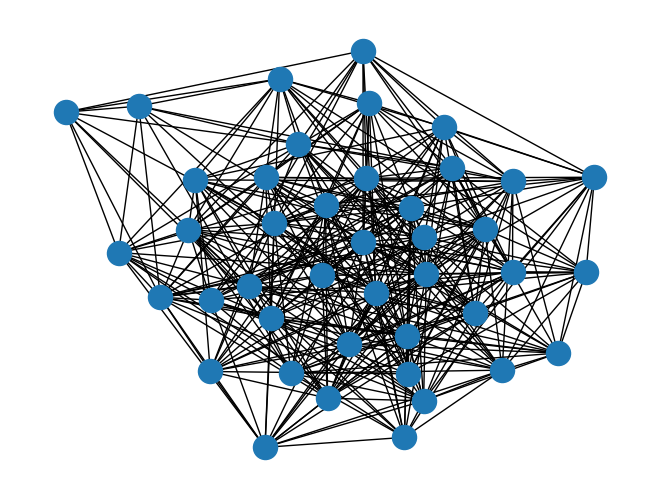

In [12]:
nx.draw(G)

In [13]:
feature_gan.generate_feat()

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 0.],
         [0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.],
         [1., 0., 0.],
         [1., 1., 0.],
         [1., 0., 0.],
         [1., 1., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]])